In [2]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# !pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import learning_curve
# from yellowbrick.model_selection import learning_curve


# SMOTE and Near Miss
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

# !pip install 'aif360[AdversarialDebiasing]'
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
# from aif360.algorithms.preprocessing import Reweighing

plt.style.use("fivethirtyeight")

from IPython.display import display, HTML

import warnings
print('Ok')

Ok


In [3]:
%%time
data = pd.read_csv("""..\data\interim\data_100000-15percent.csv""")
# data = pd.read_csv("""../data/interim/data_100000-5percent.csv""")
data2 = data.drop(['customer'], axis=1)
# data2 = data2.drop(['tenure'], axis=1)
# data2 = data2.drop(['comeback_product'], axis=1)

data2['gender'] = data2['gender'].astype(int)
# data2['churn'] = data2['churn'].astype(object)
data2['is_senior'] = data2['is_senior'].astype(int)
data2['contract_period'] = data2['contract_period'].astype(object)

numerical = data2.select_dtypes(['number']).columns
print(f'Numerical: {numerical}\n')

categorical = data2.columns.difference(numerical)

data2[categorical] = data2[categorical].astype('object')
print(f'Categorical: {categorical}')

data2 = pd.get_dummies(data2)

X_original = data2.drop('churn', axis=1)
y_original = data2['churn']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)
print(len(data2.keys()))
data2.keys()

Numerical: Index(['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage'],
      dtype='object')

Categorical: Index(['contract_period', 'race', 't_location'], dtype='object')
46
Wall time: 174 ms


Index(['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage', 'race_B', 'race_C',
       'race_I', 'race_M', 'race_O', 't_location_Zone-AJP',
       't_location_Zone-AKM', 't_location_Zone-BAL', 't_location_Zone-BKK',
       't_location_Zone-BLS', 't_location_Zone-CSM', 't_location_Zone-GCK',
       't_location_Zone-GHP', 't_location_Zone-GPP', 't_location_Zone-GRT',
       't_location_Zone-IRM', 't_location_Zone-KDS', 't_location_Zone-KRP',
       't_location_Zone-NSN', 't_location_Zone-PBP', 't_location_Zone-PDK',
       't_location_Zone-RLK', 't_location_Zone-SRJ', 't_location_Zone-TLK',
       't_location_Zone-TLS', 't_location_Zone-UBS', 't_location_Zone-URJ',
       't_location_Zone-UWT', 'contract_period_1', 'contract_period_12',
       'contract_period_18', 'contract_period_24', 'contract_period_36'],
      dtype='object')

In [4]:
models = []
models.append(('Random Forest', RandomForestClassifier()))
models.append(("LightGBM", LGBMClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Logistic Reg.', LogisticRegression(max_iter=1000)))

models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))

methods = ['original', 'adasyn', 'smote', 'rus', 'ros']

In [5]:
# AIF360 Dataset Preparation

all_labels = ['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage', 'race_B', 'race_C',
       'race_I', 'race_M', 'race_O', 't_location_Zone-AJP',
       't_location_Zone-AKM', 't_location_Zone-BAL', 't_location_Zone-BKK',
       't_location_Zone-BLS', 't_location_Zone-CSM', 't_location_Zone-GCK',
       't_location_Zone-GHP', 't_location_Zone-GPP', 't_location_Zone-GRT',
       't_location_Zone-IRM', 't_location_Zone-KDS', 't_location_Zone-KRP',
       't_location_Zone-NSN', 't_location_Zone-PBP', 't_location_Zone-PDK',
       't_location_Zone-RLK', 't_location_Zone-SRJ', 't_location_Zone-TLK',
       't_location_Zone-TLS', 't_location_Zone-UBS', 't_location_Zone-URJ',
       't_location_Zone-UWT', 
        # 'contract_period_1', 
        'contract_period_12',
       'contract_period_18', 'contract_period_24', 'contract_period_36']

features = ['age', 'gender', 'hsbb_area', 'speed', 'price_start', 'complain_count',
       'churn', 'median_outstanding', 'technical_problem_count', 'is_senior',
       'avg_download', 'avg_upload', 'avg_voice_usage', 'race_B', 'race_C',
       'race_I', 'race_M', 'race_O', 't_location_Zone-AJP',
       't_location_Zone-AKM', 't_location_Zone-BAL', 't_location_Zone-BKK',
       't_location_Zone-BLS', 't_location_Zone-CSM', 't_location_Zone-GCK',
       't_location_Zone-GHP', 't_location_Zone-GPP', 't_location_Zone-GRT',
       't_location_Zone-IRM', 't_location_Zone-KDS', 't_location_Zone-KRP',
       't_location_Zone-NSN', 't_location_Zone-PBP', 't_location_Zone-PDK',
       't_location_Zone-RLK', 't_location_Zone-SRJ', 't_location_Zone-TLK',
       't_location_Zone-TLS', 't_location_Zone-UBS', 't_location_Zone-URJ',
       't_location_Zone-UWT', 
        # 'contract_period_1', 
        'contract_period_12',
       'contract_period_18', 'contract_period_24', 'contract_period_36']


class TMDataset(StandardDataset):
    def __init__(self, 
             label_name='churn',
             favorable_classes=[1.0],
                 
             protected_attribute_names=[
                'gender', 
#                 'is_senior',
#                 'race_O',
             ],
    
             privileged_classes=[
                [1.0,], 
#                 [0.0,],
#                 [0.0,],
             ],
                 
             instance_weights_name=None,
             categorical_features=[],
             features_to_keep=features, 
             features_to_drop=[],
             custom_preprocessing=None,
             metadata=None,
             csv_file_name='',
             data_frame=None,
    ):
        
        if data_frame is not None:
            aif_df = data_frame
        else:
            aif_df = pd.read_csv(csv_file_name)
        
        #df.reset_index(drop=True, inplace=True)
        # Preprocessing
        
        super().__init__(
            df=aif_df, label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            privileged_classes=privileged_classes,
            instance_weights_name=instance_weights_name,
            categorical_features=categorical_features,
            features_to_keep=features_to_keep,
            features_to_drop=features_to_drop,
            custom_preprocessing=custom_preprocessing, 
            metadata=metadata,
     
        )

In [6]:
def make_sampling(method_name, X, y):
    if method_name == 'original':
        return (X, y)
    elif method_name == 'adasyn':
        adasyn = ADASYN(sampling_strategy='minority', random_state=420, n_neighbors=5)
        return adasyn.fit_resample(X, y)
    elif method_name == 'smote':
        os = SMOTE(random_state=41)
        return os.fit_resample(X, y)
    elif method_name == 'ros':
        random_over_sampler = RandomOverSampler(random_state=42)
        return random_over_sampler.fit_resample(X, y)
    elif method_name == 'rus':
        random_under_sampler = RandomUnderSampler(random_state=42)
        return random_under_sampler.fit_resample(X, y)
    else:
        print('UNKNOWN METHOD !!') 


In [7]:
def create_learningcurve(classfier, X, y):
    # classfier = model
    # print('Process started at {}'.format(datetime.datetime.now())) 
    train_sizes_initial = np.linspace(0.01, 1.0, 50)
    train_sizes, train_scores, test_scores = learning_curve(
        classfier, X, y, cv=10, scoring='accuracy', 
        n_jobs=-1, train_sizes=train_sizes_initial)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()

    plt.pause(0.05)
    # print('Process end at {}'.format(datetime.datetime.now())) 
    # print(learning_curve(model, X, y, cv=30, scoring='accuracy'))

    # end plot

In [8]:
def runModels(model_index, method_index):
    name, model = models[model_index - 1]
    method = methods[method_index - 1]
    display(HTML(f'<h2>{model_index}.{method_index} {name} - {method} </h2>'))
    time.sleep(1)
    
    time.sleep(1)
    method_index += 1
    # display(HTML(f'<h3> {model_index}.{method_index} {method} </h3>'))
    X, y = make_sampling(method, X_original, y_original)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)
    score = cross_val_score(model, X, y, cv = 10, scoring='accuracy')

    print('Charn values Original')
    print(y.value_counts())
    print('Total data: {}'.format(y.count()))

    print('\nCharn values Train')
    print(y_train.value_counts())
    print('Total data: {}'.format(y_train.count()))

    print('\nCharn values Test')
    print(y_test.value_counts())
    print('Total data: {}'.format(y_test.count()))

    print("\n")
    print("*_" * 20)
    print(f"Mean scores : {score.mean()}")

    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(metrics.classification_report(y_pred_test, y_test))

    # Learning curve start
    print('Creating Learning curve for {} - {}'.format(name, method))
    %time create_learningcurve(model, X, y)

    pred_df = X_test.copy()
    pred_df['churn'] = y_pred_test

    print('\n Gender Count in predited value with X_test set')
    print('# ' * 10)
    print(pred_df.gender.value_counts())
    p_df = pred_df[['churn', 'gender']]
    print('\n')
    p_df.insert(2, 'counter', 1)
    print(p_df.groupby(['churn','gender',]).sum())
    print('# ' * 10)

    print(metrics.confusion_matrix(y_test, y_pred_test))
    metrics.plot_confusion_matrix(model, X_test, y_test)
    plt.show()

    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_test, y_proba)
    print('\n\n')
    print(f'ROC AUC Score {roc_auc_score}')


    # Additional matrix
    df_pred = X_test
    df_pred.reset_index(drop=True, inplace=True)

    pred = pd.Series(y_pred_test)
    df_pred = df_pred.assign(churn=pred)

    # df_pred = df_pred.assign(churn=y_test)

    aif_df = TMDataset(data_frame=df_pred)
    aif_df_labeled = aif_df.copy()
    aif_df_labeled.labels = y_pred_test

    result_tbl_cols = [
        'Attribute',
        'Mean difference', 
        'Positive Outcome',
        'Negative', 
        'Differences', 
        'Disparate impact', 
        'Consistency',
        'Statistical parity dif',
    ]

    result_rows = []
    for p_attribute in aif_df.protected_attribute_names:
        result_row = []
        privileged_groups = [{p_attribute: 1}]
        print(' * ' * 10)
        print(privileged_groups)
        unprivileged_groups = [{p_attribute: 0}]

        metric_orig_train = BinaryLabelDatasetMetric(
            aif_df,  unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        clsf_metric = ClassificationMetric(
            aif_df, aif_df_labeled, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

        print('\n AIF 360 ')
        print('\n Statistical parity difference', clsf_metric.statistical_parity_difference())

        print('\n True possitve rate {} \t True negative rate {} '.format(
            clsf_metric.true_positive_rate(), clsf_metric.true_negative_rate()))

        print('\n Desparate impact ', clsf_metric.disparate_impact())
        print('\n Equal opportunity difference ', clsf_metric.equal_opportunity_difference())
        print('\n Average odds difference ', clsf_metric.average_odds_difference())
        print('\n Theil Index ', clsf_metric.theil_index())
        print('\n Binary Confusion Matric ')
        print(clsf_metric.binary_confusion_matrix())
        print('\n ..........................')

        text_expl = MetricTextExplainer(metric_orig_train)

        result_row.append(p_attribute)
        result_row.append(metric_orig_train.mean_difference())
        result_row.append(metric_orig_train.num_positives())
        result_row.append(metric_orig_train.num_negatives())

        # this is to shutup the warning msg from sklearn
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', FutureWarning)
            result_row.append(metric_orig_train.consistency())

        result_row.append(metric_orig_train.disparate_impact())
        result_row.append(metric_orig_train.consistency())
        result_row.append(metric_orig_train.statistical_parity_difference())

        result_rows.append(result_row)

    result_df = pd.DataFrame(result_rows, columns=result_tbl_cols)
    display(result_df)
    # End Aif matrix

Charn values Original
0    85000
1    15000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    56927
1    10073
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    28073
1     4927
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8954600000000001
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     30631
           1       0.40      0.83      0.54      2369

    accuracy                           0.90     33000
   macro avg       0.69      0.87      0.74     33000
weighted avg       0.94      0.90      0.91     33000

Creating Learning curve for Random Forest - original


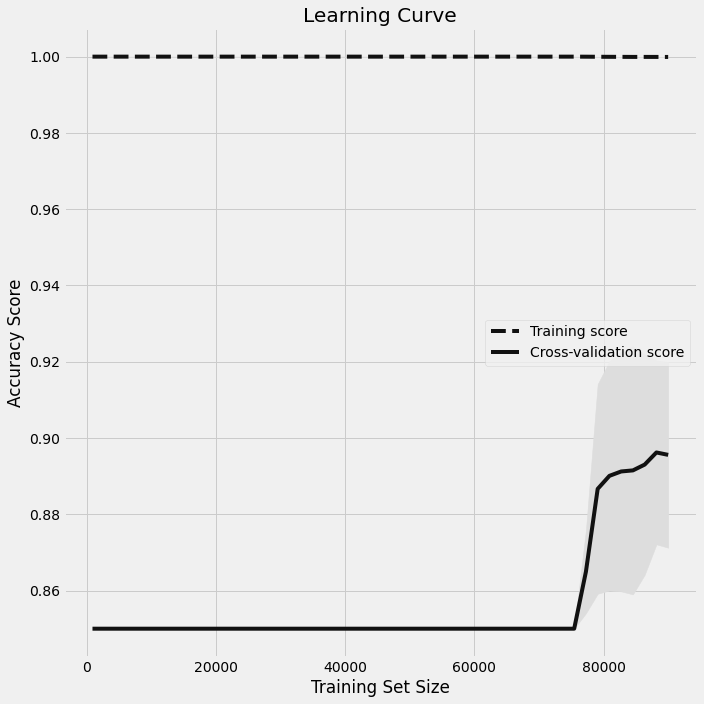

Wall time: 2min 41s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20139
0    12861
Name: gender, dtype: int64


              counter
churn gender         
0     0         12019
      1         18612
1     0           842
      1          1527
# # # # # # # # # # 
[[27663   410]
 [ 2968  1959]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


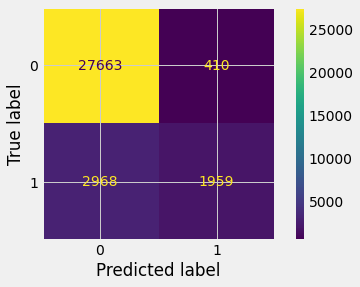




ROC AUC Score 0.83015653013027
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.010353781827449213

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8634480601028162

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 2369.0, 'FP': 0.0, 'TN': 30631.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.010354,2369.0,30631.0,[0.9793393939393938],0.863448,[0.9793393939393938],-0.010354


Wall time: 4min 43s


In [9]:
%%time
# Random Forest Original
runModels(1, 1)

Charn values Original
1    85913
0    85000
Name: churn, dtype: int64
Total data: 170913

Charn values Train
1    57569
0    56942
Name: churn, dtype: int64
Total data: 114511

Charn values Test
1    28344
0    28058
Name: churn, dtype: int64
Total data: 56402


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.923273014567483
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     30086
           1       0.90      0.97      0.93     26316

    accuracy                           0.93     56402
   macro avg       0.93      0.93      0.93     56402
weighted avg       0.93      0.93      0.93     56402

Creating Learning curve for Random Forest - adasyn


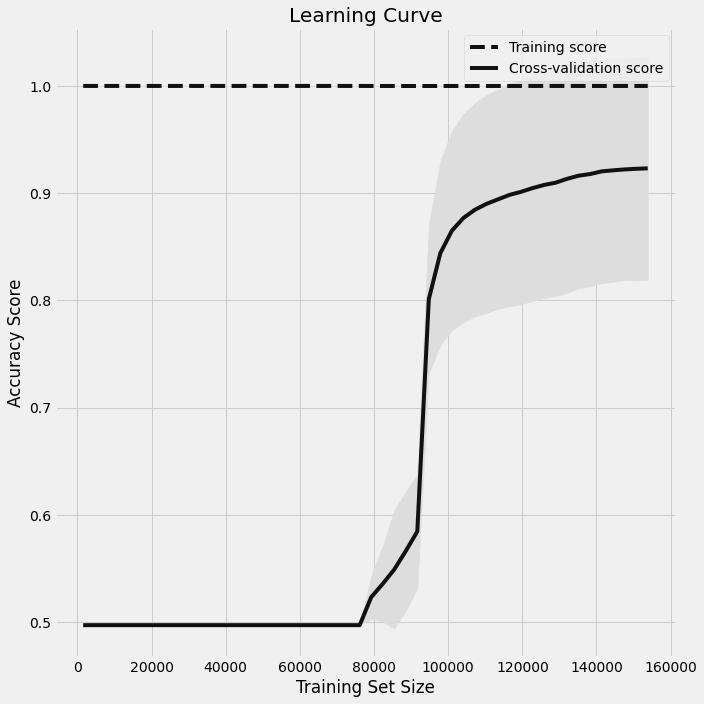

Wall time: 11min 22s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30036
0    26366
Name: gender, dtype: int64


              counter
churn gender         
0     0         11799
      1         18287
1     0         14567
      1         11749
# # # # # # # # # # 
[[27146   912]
 [ 2940 25404]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


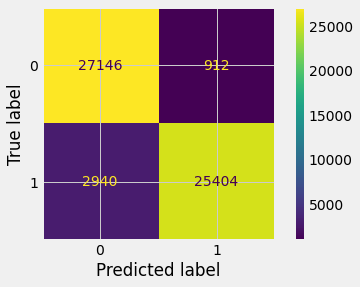




ROC AUC Score 0.9700988318077548
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.16132790894927196

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.4124304258405254

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 26316.0, 'FP': 0.0, 'TN': 30086.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.161328,26316.0,30086.0,[0.7280557427041224],1.41243,[0.7280557427041224],0.161328


Wall time: 15min 29s


In [10]:
%%time
# Random Forest [Adasyn]
runModels(1, 2)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.9284058823529412
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     30208
           1       0.89      0.97      0.93     25892

    accuracy                           0.93     56100
   macro avg       0.93      0.93      0.93     56100
weighted avg       0.93      0.93      0.93     56100

Creating Learning curve for Random Forest - smote


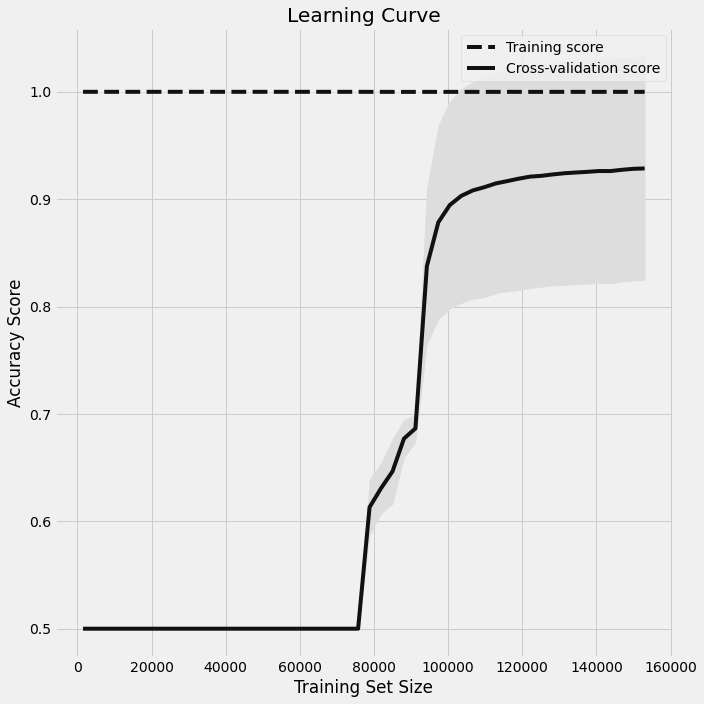

Wall time: 11min 50s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30408
0    25692
Name: gender, dtype: int64


              counter
churn gender         
0     0         11869
      1         18339
1     0         13823
      1         12069
# # # # # # # # # # 
[[27117   834]
 [ 3091 25058]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


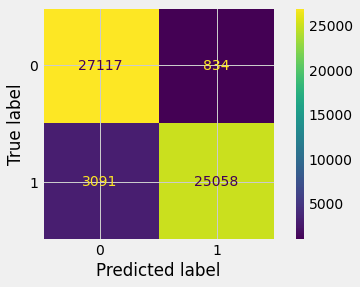




ROC AUC Score 0.9690978175942632
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.14112527050761364

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.355566925643841

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25892.0, 'FP': 0.0, 'TN': 30208.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.141125,25892.0,30208.0,[0.776887700534745],1.355567,[0.776887700534745],0.141125


Wall time: 15min 33s


In [11]:
%%time
# Random Forest [Smote]
runModels(1, 3)

Charn values Original
1    15000
0    15000
Name: churn, dtype: int64
Total data: 30000

Charn values Train
1    10096
0    10004
Name: churn, dtype: int64
Total data: 20100

Charn values Test
0    4996
1    4904
Name: churn, dtype: int64
Total data: 9900


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7454999999999999
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      5561
           1       0.69      0.78      0.74      4339

    accuracy                           0.75      9900
   macro avg       0.75      0.76      0.75      9900
weighted avg       0.76      0.75      0.75      9900

Creating Learning curve for Random Forest - rus


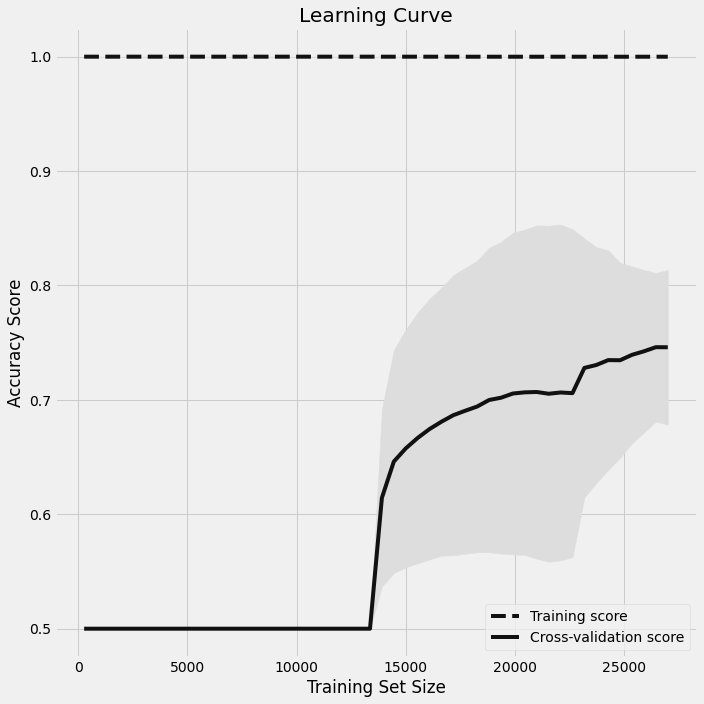

Wall time: 1min 12s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    6224
0    3676
Name: gender, dtype: int64


              counter
churn gender         
0     0          2172
      1          3389
1     0          1504
      1          2835
# # # # # # # # # # 
[[4059  937]
 [1502 3402]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


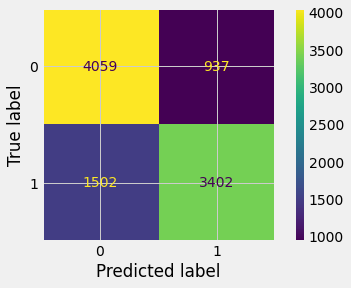




ROC AUC Score 0.8332863476752038
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.046354488644469394

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8982326852475564

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 4339.0, 'FP': 0.0, 'TN': 5561.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.046354,4339.0,5561.0,[0.7582828282828249],0.898233,[0.7582828282828249],-0.046354


Wall time: 1min 41s


In [12]:
%%time
# Random Forest [Rus]
runModels(1, 4)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.9825470588235294
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26905
           1       0.99      0.95      0.97     29195

    accuracy                           0.97     56100
   macro avg       0.97      0.97      0.97     56100
weighted avg       0.97      0.97      0.97     56100

Creating Learning curve for Random Forest - ros


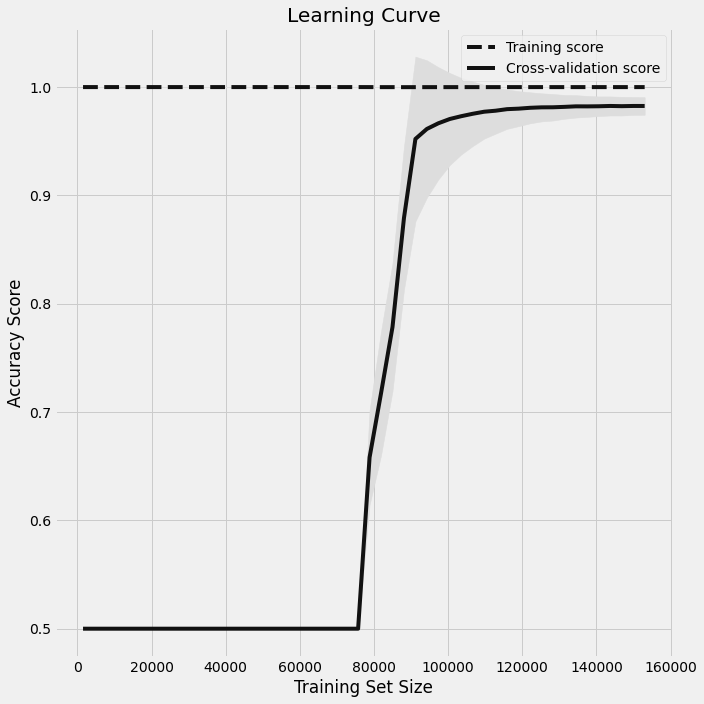

Wall time: 11min 54s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    35231
0    20869
Name: gender, dtype: int64


              counter
churn gender         
0     0         10767
      1         16138
1     0         10102
      1         19093
# # # # # # # # # # 
[[26572  1379]
 [  333 27816]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


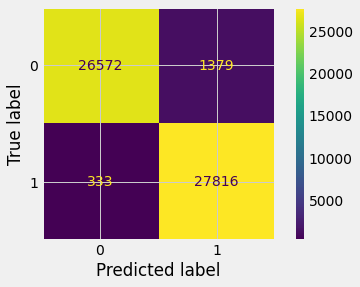




ROC AUC Score 0.9943880319357158
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.05787022140391351

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8932160597977647

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 29195.0, 'FP': 0.0, 'TN': 26905.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.05787,29195.0,26905.0,[0.7810481283422347],0.893216,[0.7810481283422347],-0.05787


Wall time: 15min 21s


In [13]:
%%time
# Random Forest [Ros]
runModels(1, 5)

Charn values Original
0    85000
1    15000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    56927
1    10073
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    28073
1     4927
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8974400000000001
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     30594
           1       0.40      0.83      0.54      2406

    accuracy                           0.90     33000
   macro avg       0.69      0.86      0.74     33000
weighted avg       0.94      0.90      0.91     33000

Creating Learning curve for LightGBM - original


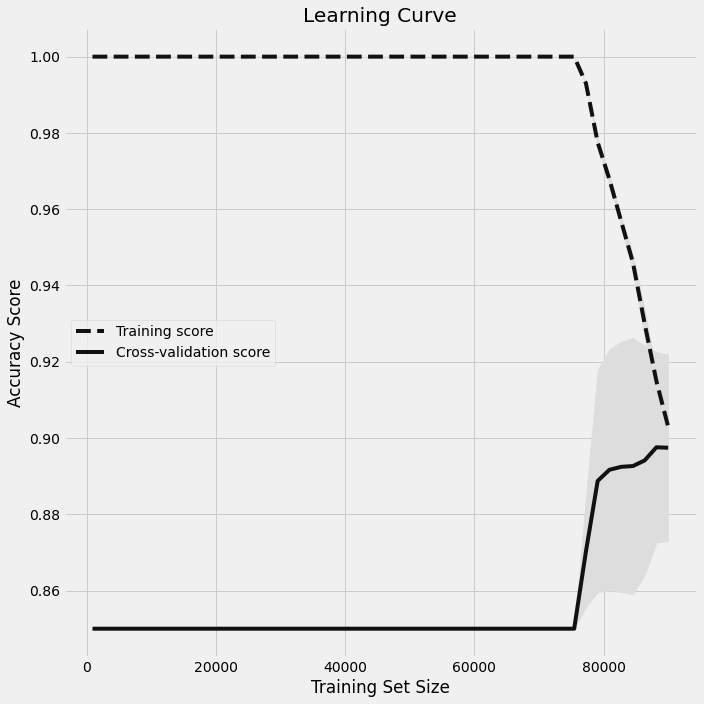

Wall time: 21.4 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20139
0    12861
Name: gender, dtype: int64


              counter
churn gender         
0     0         12010
      1         18584
1     0           851
      1          1555
# # # # # # # # # # 
[[27654   419]
 [ 2940  1987]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


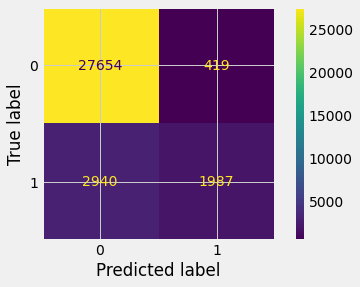




ROC AUC Score 0.8444163098482167
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.011044328921228627

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.856963511161014

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 2406.0, 'FP': 0.0, 'TN': 30594.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.011044,2406.0,30594.0,[0.9793333333333333],0.856964,[0.9793333333333333],-0.011044


Wall time: 28.8 s


In [14]:
%%time
runModels(2, 1)

Charn values Original
1    85913
0    85000
Name: churn, dtype: int64
Total data: 170913

Charn values Train
1    57569
0    56942
Name: churn, dtype: int64
Total data: 114511

Charn values Test
1    28344
0    28058
Name: churn, dtype: int64
Total data: 56402


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.9243090030331848
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     30643
           1       0.89      0.98      0.93     25759

    accuracy                           0.94     56402
   macro avg       0.94      0.94      0.94     56402
weighted avg       0.94      0.94      0.94     56402

Creating Learning curve for LightGBM - adasyn


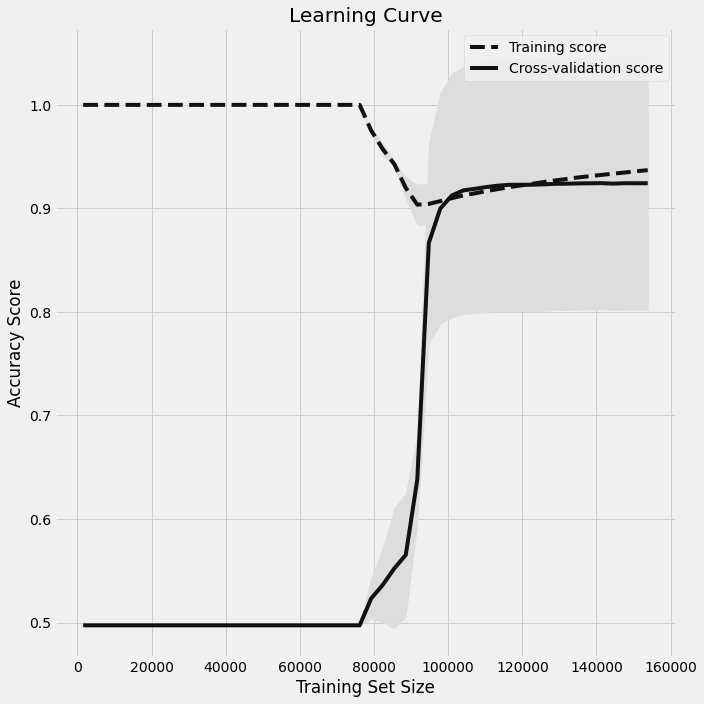

Wall time: 1min 4s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30036
0    26366
Name: gender, dtype: int64


              counter
churn gender         
0     0         12090
      1         18553
1     0         14276
      1         11483
# # # # # # # # # # 
[[27555   503]
 [ 3088 25256]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


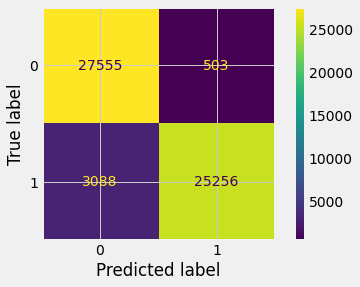




ROC AUC Score 0.9708905745964264
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.15914700685304722

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.4162796741128736

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25759.0, 'FP': 0.0, 'TN': 30643.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.159147,25759.0,30643.0,[0.7275628523810846],1.41628,[0.7275628523810846],0.159147


Wall time: 1min 43s


In [15]:
%%time
runModels(2, 2)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.929764705882353
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     30558
           1       0.89      0.98      0.93     25542

    accuracy                           0.94     56100
   macro avg       0.94      0.94      0.94     56100
weighted avg       0.94      0.94      0.94     56100

Creating Learning curve for LightGBM - smote


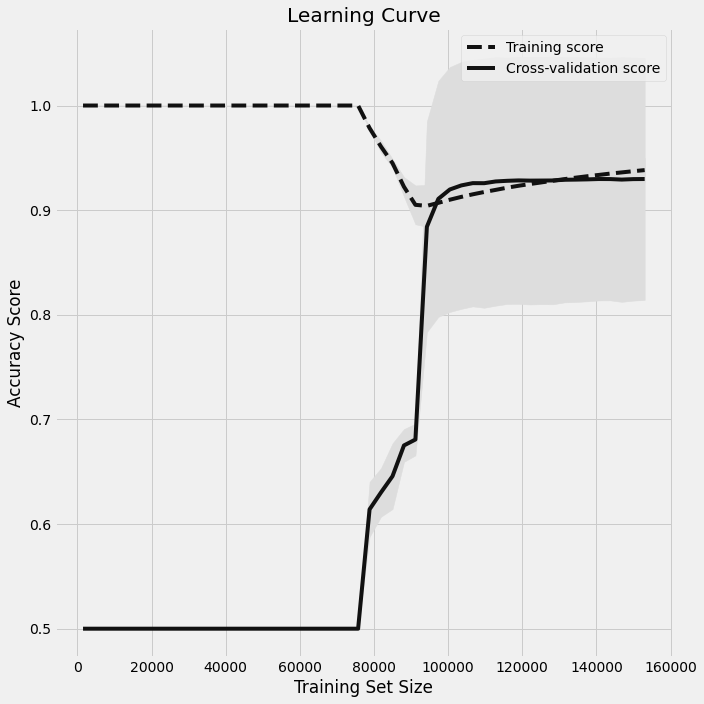

Wall time: 1min 3s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30408
0    25692
Name: gender, dtype: int64


              counter
churn gender         
0     0         12003
      1         18555
1     0         13689
      1         11853
# # # # # # # # # # 
[[27448   503]
 [ 3110 25039]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


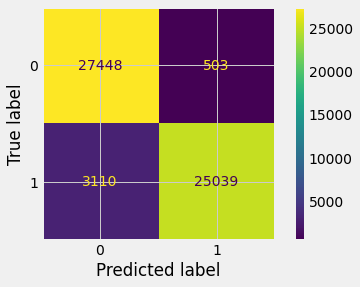




ROC AUC Score 0.970573978978928
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.14301303302641294

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.3668894210973732

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25542.0, 'FP': 0.0, 'TN': 30558.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.143013,25542.0,30558.0,[0.7786987522281501],1.366889,[0.7786987522281501],0.143013


Wall time: 1min 23s


In [16]:
%%time
runModels(2, 3)

Charn values Original
1    15000
0    15000
Name: churn, dtype: int64
Total data: 30000

Charn values Train
1    10096
0    10004
Name: churn, dtype: int64
Total data: 20100

Charn values Test
0    4996
1    4904
Name: churn, dtype: int64
Total data: 9900


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7516333333333334
              precision    recall  f1-score   support

           0       0.81      0.74      0.78      5497
           1       0.71      0.79      0.75      4403

    accuracy                           0.76      9900
   macro avg       0.76      0.76      0.76      9900
weighted avg       0.77      0.76      0.76      9900

Creating Learning curve for LightGBM - rus


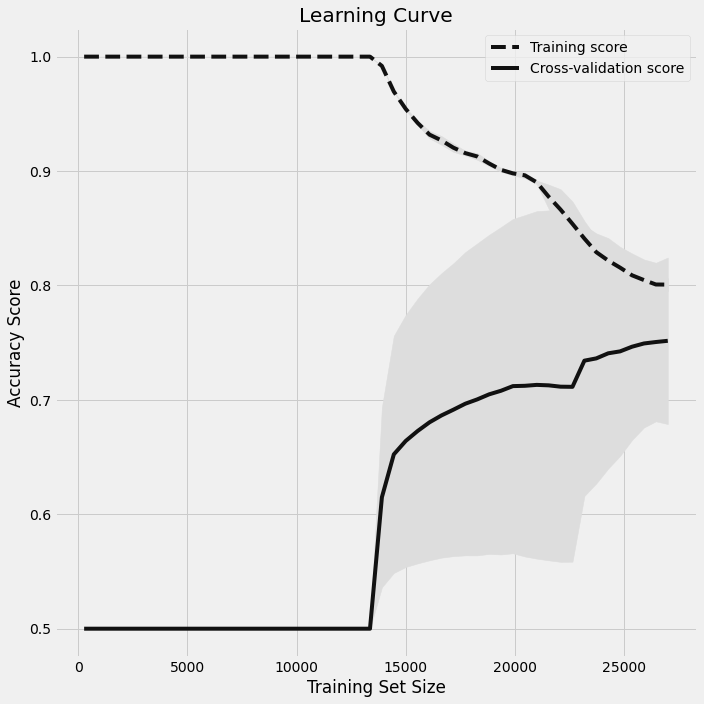

Wall time: 10.5 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    6224
0    3676
Name: gender, dtype: int64


              counter
churn gender         
0     0          2179
      1          3318
1     0          1497
      1          2906
# # # # # # # # # # 
[[4068  928]
 [1429 3475]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


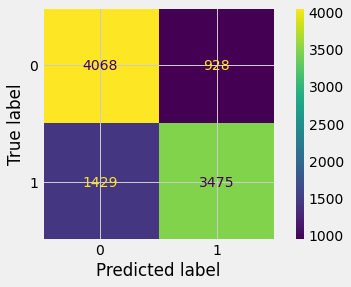




ROC AUC Score 0.8410451240274438
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.059666187400521986

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8722084134959226

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 4403.0, 'FP': 0.0, 'TN': 5497.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.059666,4403.0,5497.0,[0.7597777777777748],0.872208,[0.7597777777777748],-0.059666


Wall time: 14.7 s


In [17]:
%%time
runModels(2, 4)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7753235294117646
              precision    recall  f1-score   support

           0       0.83      0.75      0.79     30670
           1       0.73      0.81      0.77     25430

    accuracy                           0.78     56100
   macro avg       0.78      0.78      0.78     56100
weighted avg       0.78      0.78      0.78     56100

Creating Learning curve for LightGBM - ros


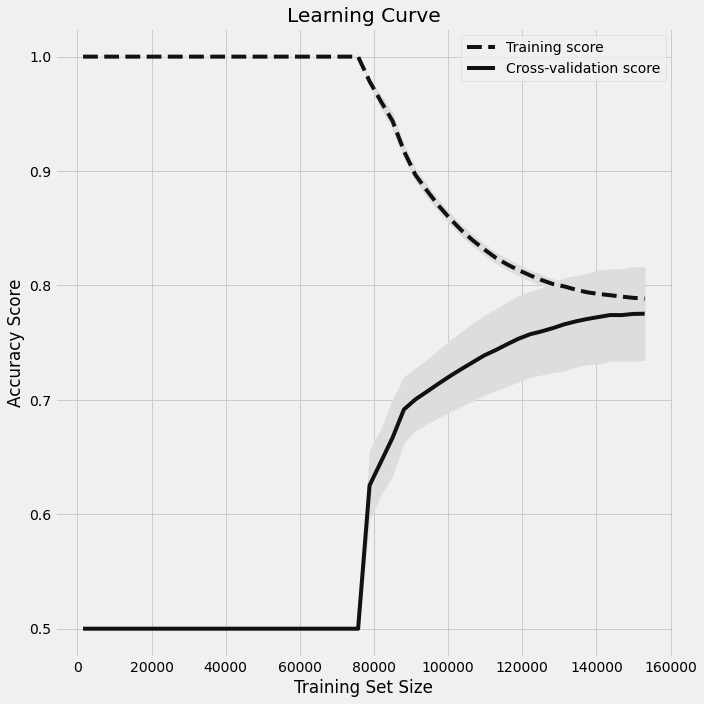

Wall time: 59.9 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    35231
0    20869
Name: gender, dtype: int64


              counter
churn gender         
0     0         12331
      1         18339
1     0          8538
      1         16892
# # # # # # # # # # 
[[23080  4871]
 [ 7590 20559]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


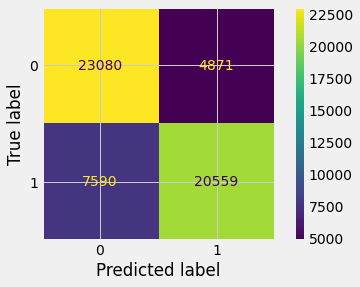




ROC AUC Score 0.865182434159827
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.07034052788339767

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.853293444360645

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25430.0, 'FP': 0.0, 'TN': 30670.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.070341,25430.0,30670.0,[0.8195115864527641],0.853293,[0.8195115864527641],-0.070341


Wall time: 1min 15s


In [18]:
%%time
runModels(2, 5)

Charn values Original
0    85000
1    15000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    56927
1    10073
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    28073
1     4927
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8964200000000002
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     30722
           1       0.39      0.84      0.53      2278

    accuracy                           0.90     33000
   macro avg       0.69      0.87      0.74     33000
weighted avg       0.95      0.90      0.91     33000

Creating Learning curve for Gradient Boosting - original


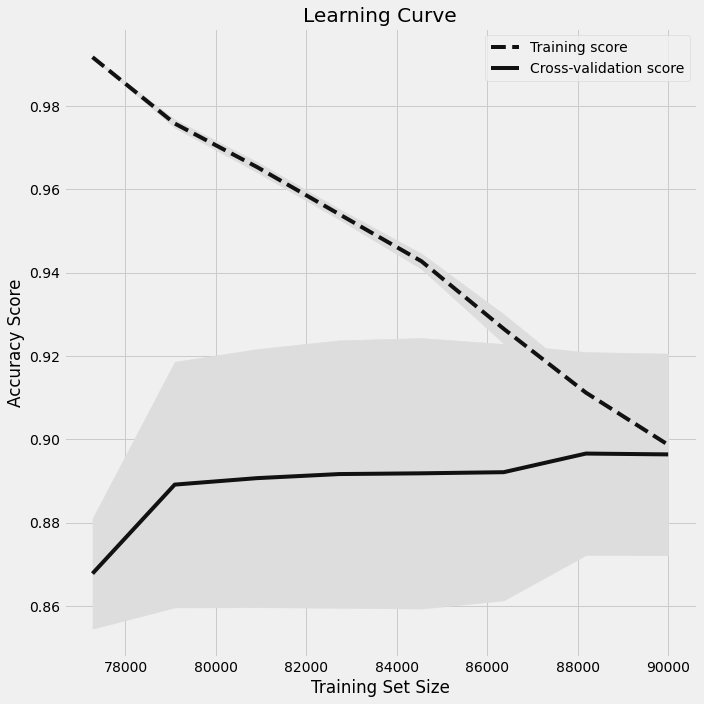

Wall time: 2min 54s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20139
0    12861
Name: gender, dtype: int64


              counter
churn gender         
0     0         12022
      1         18700
1     0           839
      1          1439
# # # # # # # # # # 
[[27701   372]
 [ 3021  1906]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


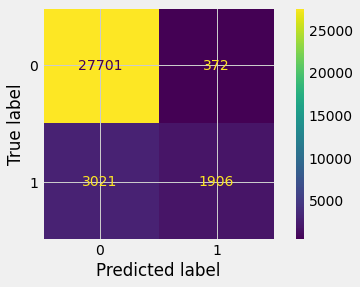




ROC AUC Score 0.8386942178084795
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.0062174141176717795

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9129864468966005

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 2278.0, 'FP': 0.0, 'TN': 30722.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.006217,2278.0,30722.0,[0.9852000000000001],0.912986,[0.9852000000000001],-0.006217


Wall time: 5min 24s


In [19]:
%%time
runModels(3, 1)

Charn values Original
1    85913
0    85000
Name: churn, dtype: int64
Total data: 170913

Charn values Train
1    57569
0    56942
Name: churn, dtype: int64
Total data: 114511

Charn values Test
1    28344
0    28058
Name: churn, dtype: int64
Total data: 56402


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.9051292599656829
              precision    recall  f1-score   support

           0       0.95      0.88      0.92     30396
           1       0.87      0.95      0.91     26006

    accuracy                           0.91     56402
   macro avg       0.91      0.92      0.91     56402
weighted avg       0.92      0.91      0.91     56402

Creating Learning curve for Gradient Boosting - adasyn


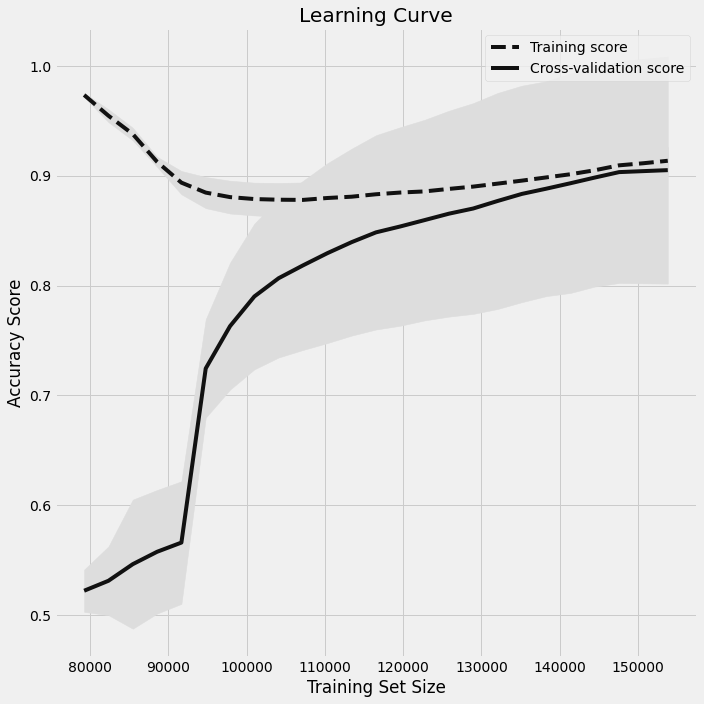

Wall time: 14min 48s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30036
0    26366
Name: gender, dtype: int64


              counter
churn gender         
0     0         11970
      1         18426
1     0         14396
      1         11610
# # # # # # # # # # 
[[26756  1302]
 [ 3640 24704]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


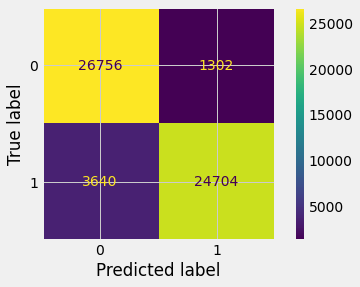




ROC AUC Score 0.9563092673522712
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.15947006351992266

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.4125618284138155

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 26006.0, 'FP': 0.0, 'TN': 30396.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.15947,26006.0,30396.0,[0.7236303677174191],1.412562,[0.7236303677174191],0.15947


Wall time: 20min 10s


In [20]:
%%time
runModels(3, 2)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.9013823529411766
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     31480
           1       0.84      0.96      0.90     24620

    accuracy                           0.90     56100
   macro avg       0.91      0.91      0.90     56100
weighted avg       0.91      0.90      0.91     56100

Creating Learning curve for Gradient Boosting - smote


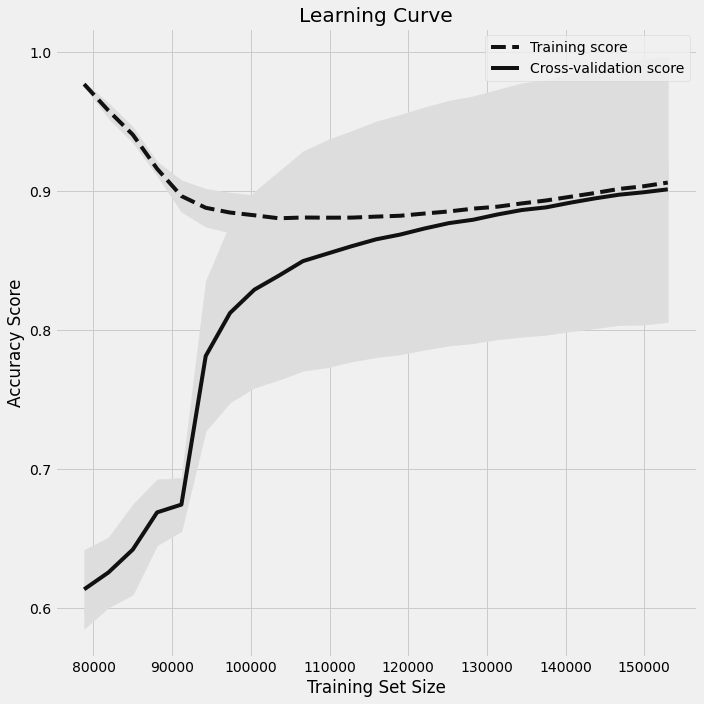

Wall time: 15min 1s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30408
0    25692
Name: gender, dtype: int64


              counter
churn gender         
0     0         12506
      1         18974
1     0         13186
      1         11434
# # # # # # # # # # 
[[27046   905]
 [ 4434 23715]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


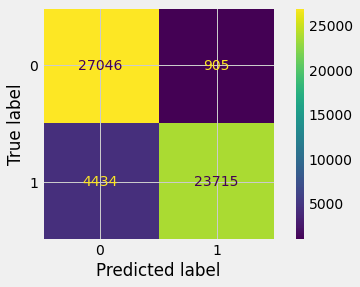




ROC AUC Score 0.9560600046950869
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.13721422286054913

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.3649125493041436

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 24620.0, 'FP': 0.0, 'TN': 31480.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.137214,24620.0,31480.0,[0.7875080213903646],1.364913,[0.7875080213903646],0.137214


Wall time: 19min 47s


In [21]:
%%time
runModels(3, 3)

Charn values Original
1    15000
0    15000
Name: churn, dtype: int64
Total data: 30000

Charn values Train
1    10096
0    10004
Name: churn, dtype: int64
Total data: 20100

Charn values Test
0    4996
1    4904
Name: churn, dtype: int64
Total data: 9900


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7460666666666668
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      5599
           1       0.69      0.79      0.74      4301

    accuracy                           0.76      9900
   macro avg       0.76      0.76      0.76      9900
weighted avg       0.77      0.76      0.76      9900

Creating Learning curve for Gradient Boosting - rus


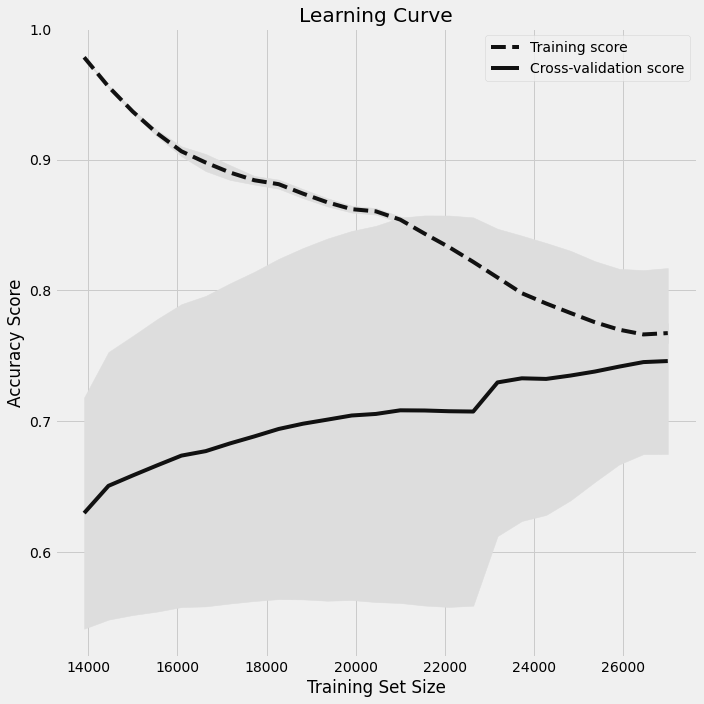

Wall time: 1min 16s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    6224
0    3676
Name: gender, dtype: int64


              counter
churn gender         
0     0          2208
      1          3391
1     0          1468
      1          2833
# # # # # # # # # # 
[[4099  897]
 [1500 3404]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


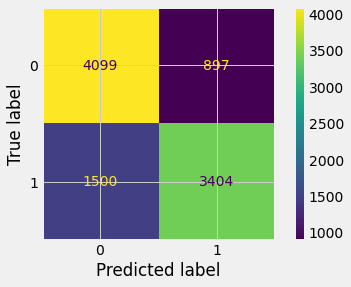




ROC AUC Score 0.8353229484076657
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.055826405419996616

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8773513775735761

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 4301.0, 'FP': 0.0, 'TN': 5599.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.055826,4301.0,5599.0,[0.7685050505050453],0.877351,[0.7685050505050453],-0.055826


Wall time: 1min 55s


In [22]:
%%time
runModels(3, 4)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7563705882352941
              precision    recall  f1-score   support

           0       0.82      0.73      0.77     31646
           1       0.69      0.80      0.74     24454

    accuracy                           0.76     56100
   macro avg       0.76      0.76      0.76     56100
weighted avg       0.77      0.76      0.76     56100

Creating Learning curve for Gradient Boosting - ros


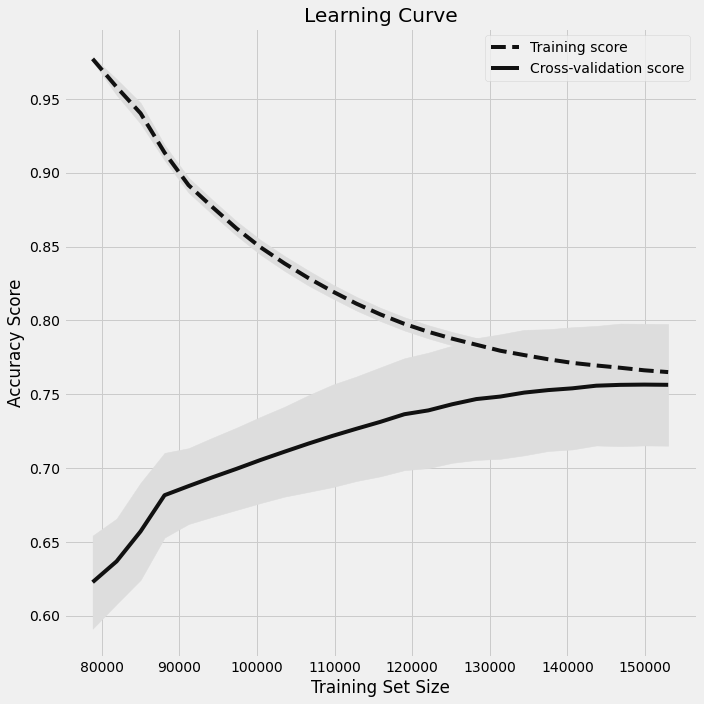

Wall time: 14min 59s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    35231
0    20869
Name: gender, dtype: int64


              counter
churn gender         
0     0         12526
      1         19120
1     0          8343
      1         16111
# # # # # # # # # # 
[[23019  4932]
 [ 8627 19522]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


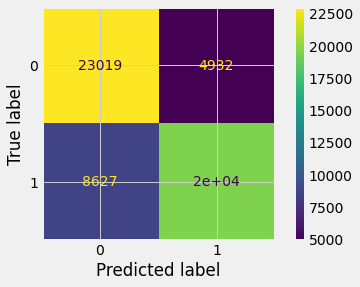




ROC AUC Score 0.8392697572553351
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.057516553884495

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8742247092108097

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 24454.0, 'FP': 0.0, 'TN': 31646.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.057517,24454.0,31646.0,[0.828987522281647],0.874225,[0.828987522281647],-0.057517


Wall time: 19min 19s


In [23]:
%%time
runModels(3, 5)

Charn values Original
0    85000
1    15000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    56927
1    10073
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    28073
1     4927
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8599500000000001
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     32430
           1       0.10      0.82      0.17       570

    accuracy                           0.86     33000
   macro avg       0.55      0.84      0.55     33000
weighted avg       0.98      0.86      0.91     33000

Creating Learning curve for Logistic Reg. - original


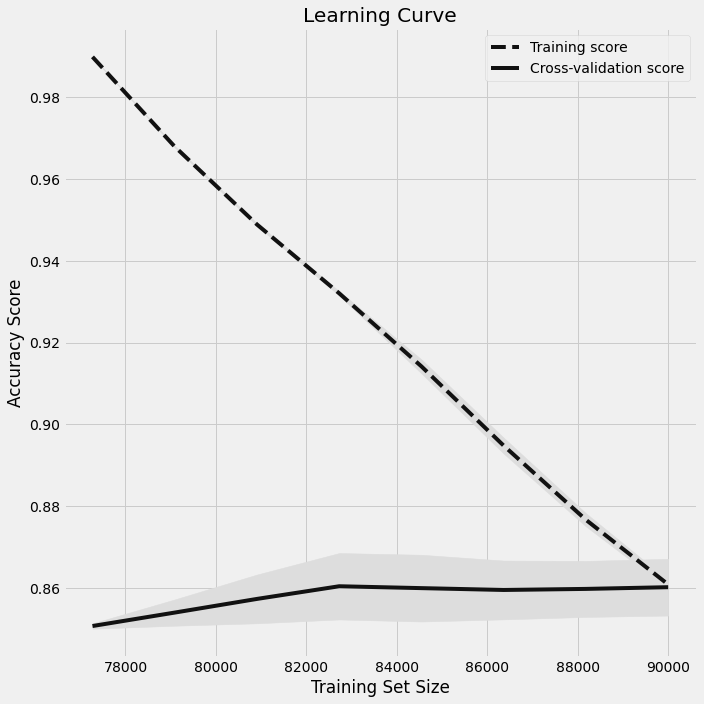

Wall time: 54.9 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20139
0    12861
Name: gender, dtype: int64


              counter
churn gender         
0     0         12652
      1         19778
1     0           209
      1           361
# # # # # # # # # # 
[[27972   101]
 [ 4458   469]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


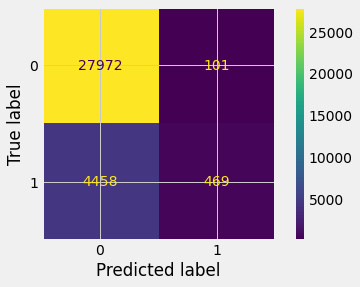




ROC AUC Score 0.7001160157766939
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.0016747379910693715

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9065718880826978

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 570.0, 'FP': 0.0, 'TN': 32430.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.001675,570.0,32430.0,[0.9951575757575758],0.906572,[0.9951575757575758],-0.001675


Wall time: 1min 8s


In [24]:
%%time
runModels(4, 1)

Charn values Original
1    85913
0    85000
Name: churn, dtype: int64
Total data: 170913

Charn values Train
1    57569
0    56942
Name: churn, dtype: int64
Total data: 114511

Charn values Test
1    28344
0    28058
Name: churn, dtype: int64
Total data: 56402


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6401160971275812
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     29545
           1       0.71      0.75      0.73     26857

    accuracy                           0.74     56402
   macro avg       0.74      0.74      0.74     56402
weighted avg       0.74      0.74      0.74     56402

Creating Learning curve for Logistic Reg. - adasyn


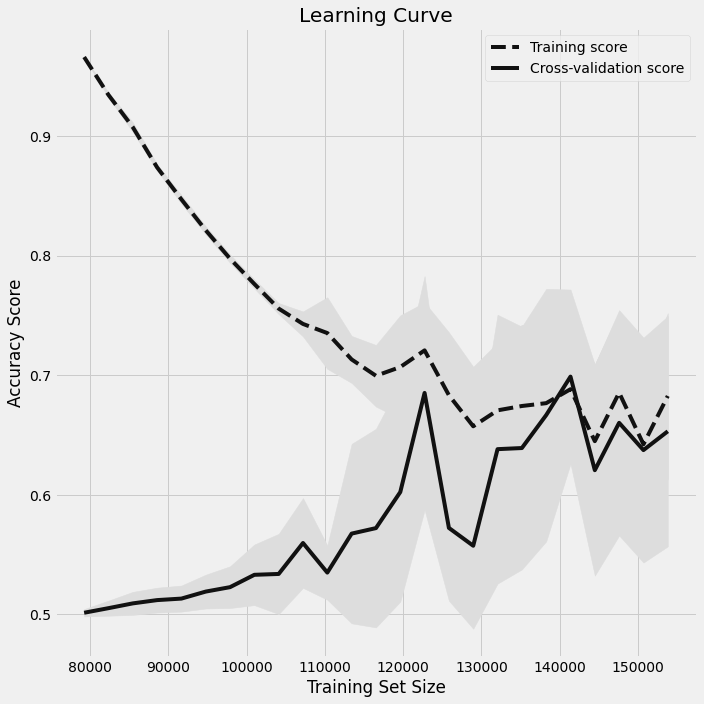

Wall time: 4min 5s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30036
0    26366
Name: gender, dtype: int64


              counter
churn gender         
0     0          7783
      1         21762
1     0         18583
      1          8274
# # # # # # # # # # 
[[21405  6653]
 [ 8140 20204]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


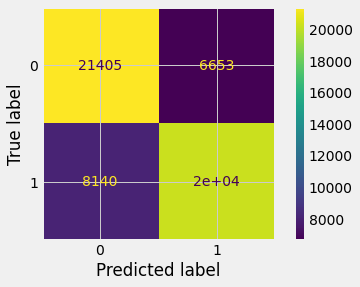




ROC AUC Score 0.8169849105408383
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.429339787324618

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  2.558575036509817

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 26857.0, 'FP': 0.0, 'TN': 29545.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.42934,26857.0,29545.0,[0.686830254246242],2.558575,[0.686830254246242],0.42934


Wall time: 5min 4s


In [25]:
%%time
runModels(4, 2)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.7006058823529411
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     29719
           1       0.71      0.76      0.73     26381

    accuracy                           0.74     56100
   macro avg       0.74      0.74      0.74     56100
weighted avg       0.74      0.74      0.74     56100

Creating Learning curve for Logistic Reg. - smote


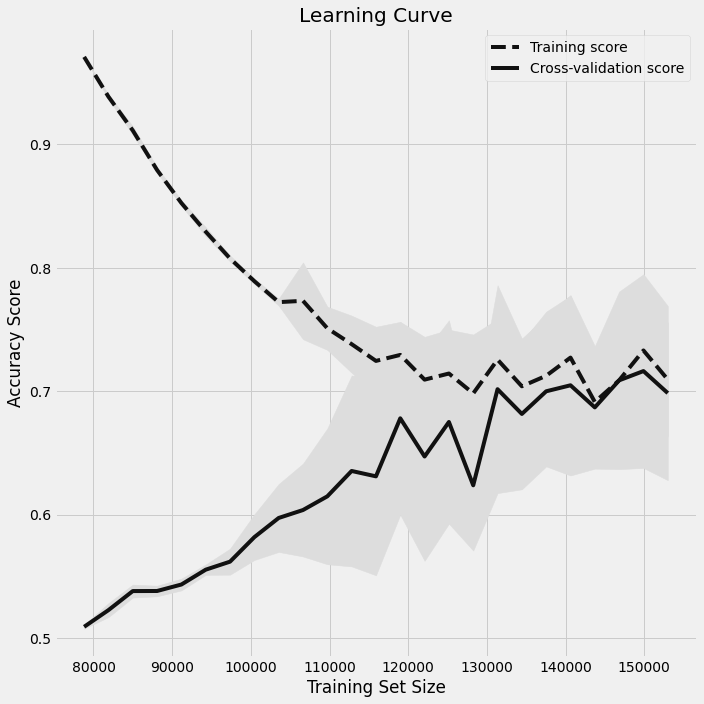

Wall time: 5min 34s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30408
0    25692
Name: gender, dtype: int64


              counter
churn gender         
0     0          8240
      1         21479
1     0         17452
      1          8929
# # # # # # # # # # 
[[21565  6386]
 [ 8154 19995]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


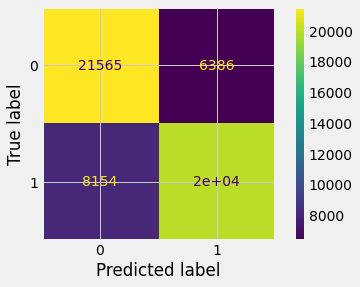




ROC AUC Score 0.8199298116516966
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.38563776451561893

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  2.313301953566014

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 26381.0, 'FP': 0.0, 'TN': 29719.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.385638,26381.0,29719.0,[0.724912655971445],2.313302,[0.724912655971445],0.385638


Wall time: 6min 22s


In [26]:
%%time
runModels(4, 3)

Charn values Original
1    15000
0    15000
Name: churn, dtype: int64
Total data: 30000

Charn values Train
1    10096
0    10004
Name: churn, dtype: int64
Total data: 20100

Charn values Test
0    4996
1    4904
Name: churn, dtype: int64
Total data: 9900


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6586666666666667
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      5058
           1       0.63      0.64      0.64      4842

    accuracy                           0.64      9900
   macro avg       0.64      0.64      0.64      9900
weighted avg       0.64      0.64      0.64      9900

Creating Learning curve for Logistic Reg. - rus


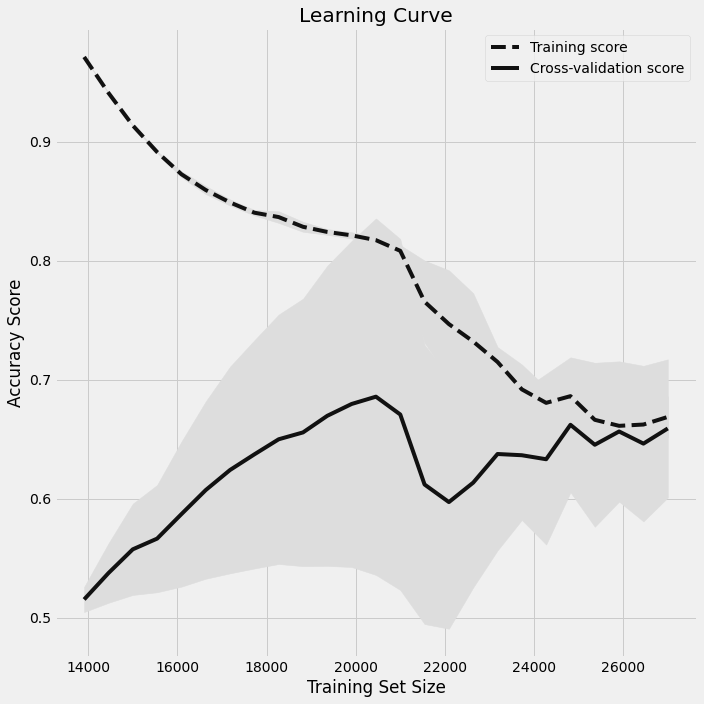

Wall time: 33.9 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    6224
0    3676
Name: gender, dtype: int64


              counter
churn gender         
0     0          1835
      1          3223
1     0          1841
      1          3001
# # # # # # # # # # 
[[3253 1743]
 [1805 3099]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


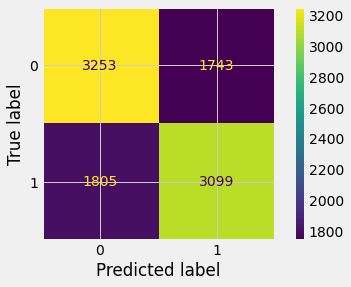




ROC AUC Score 0.6927466116449441
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.018650294692733493

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.0386802513054225

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 4842.0, 'FP': 0.0, 'TN': 5058.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.01865,4842.0,5058.0,[0.7978181818181741],1.03868,[0.7978181818181741],0.01865


Wall time: 38.9 s


In [27]:
%%time
runModels(4, 4)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6684411764705882
              precision    recall  f1-score   support

           0       0.73      0.66      0.70     30603
           1       0.64      0.70      0.67     25497

    accuracy                           0.68     56100
   macro avg       0.68      0.68      0.68     56100
weighted avg       0.69      0.68      0.68     56100

Creating Learning curve for Logistic Reg. - ros


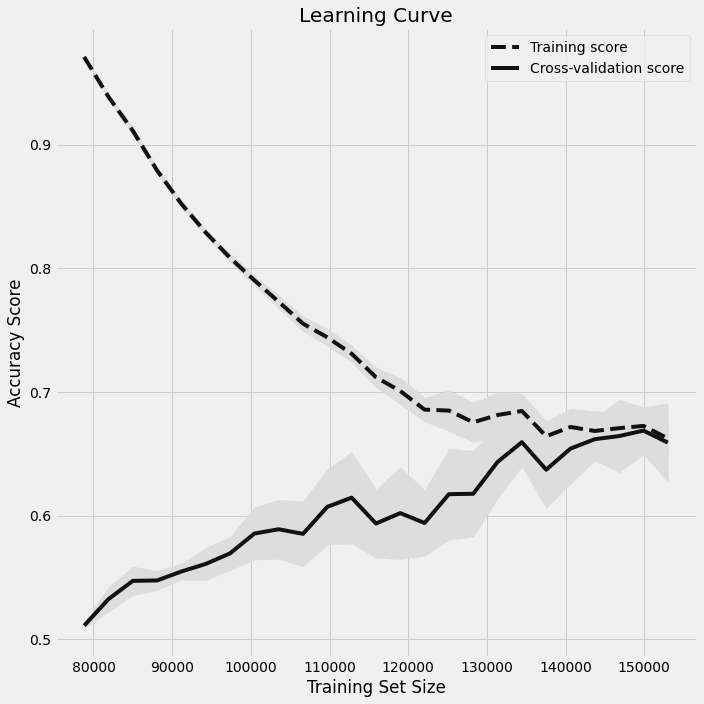

Wall time: 3min 47s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    35231
0    20869
Name: gender, dtype: int64


              counter
churn gender         
0     0         12700
      1         17903
1     0          8169
      1         17328
# # # # # # # # # # 
[[20350  7601]
 [10253 17896]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


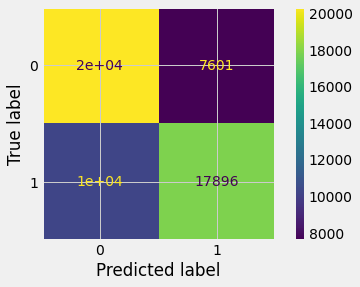




ROC AUC Score 0.7431838967788896
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.1003977215530868

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.7958730304687903

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25497.0, 'FP': 0.0, 'TN': 30603.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.100398,25497.0,30603.0,[0.7733012477718194],0.795873,[0.7733012477718194],-0.100398


Wall time: 4min 20s


In [28]:
%%time
runModels(4, 5)

In [29]:
import warnings
warnings.filterwarnings('ignore')

[19:19:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

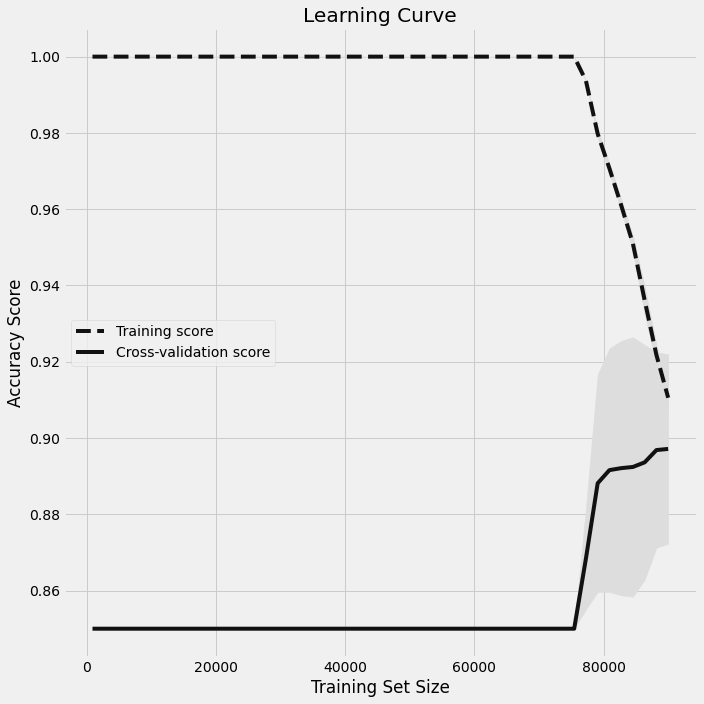

Wall time: 3min 10s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20139
0    12861
Name: gender, dtype: int64


              counter
churn gender         
0     0         11961
      1         18508
1     0           900
      1          1631
# # # # # # # # # # 
[[27593   480]
 [ 2876  2051]]


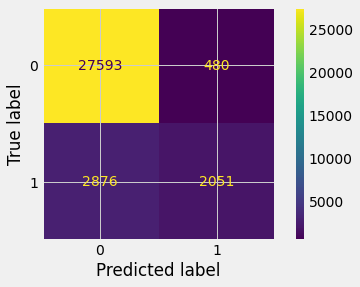




ROC AUC Score 0.8389918775002726
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.011008133083189403

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.864075541286112

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 2531.0, 'FP': 0.0, 'TN': 30469.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.011008,2531.0,30469.0,[0.9728060606060601],0.864076,[0.9728060606060601],-0.011008


Wall time: 3min 44s


In [30]:
%%time
runModels(5, 1)

[19:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

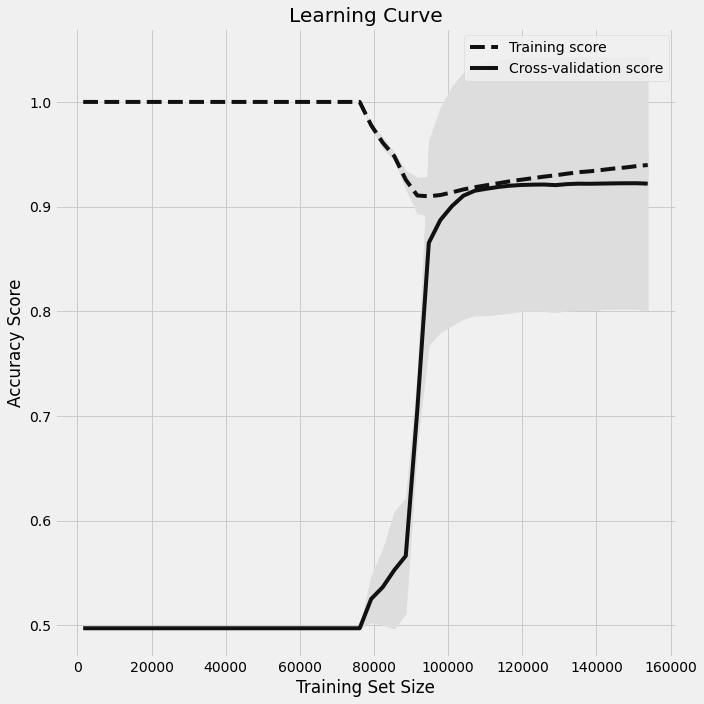

Wall time: 9min 45s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30036
0    26366
Name: gender, dtype: int64


              counter
churn gender         
0     0         12017
      1         18486
1     0         14349
      1         11550
# # # # # # # # # # 
[[27423   635]
 [ 3080 25264]]


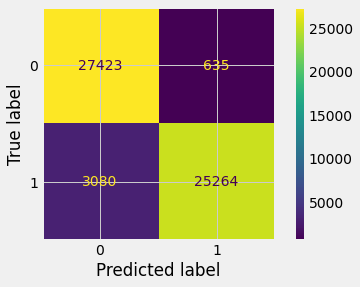




ROC AUC Score 0.9698006629779246
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.15968506759498402

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.415264129028826

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25899.0, 'FP': 0.0, 'TN': 30503.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.159685,25899.0,30503.0,[0.72663380731176],1.415264,[0.72663380731176],0.159685


Wall time: 11min 8s


In [31]:
%%time
runModels(5, 2)

[19:34:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

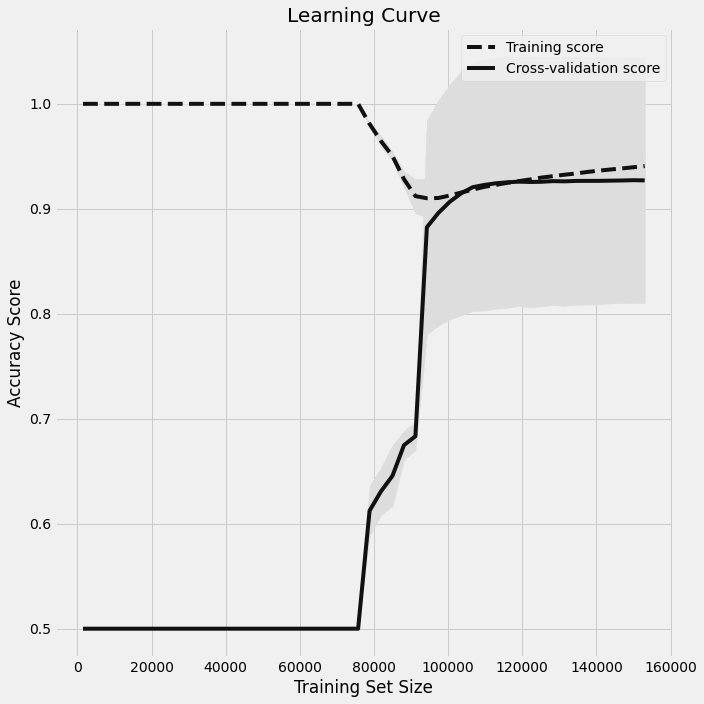

Wall time: 10min 3s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30408
0    25692
Name: gender, dtype: int64


              counter
churn gender         
0     0         11952
      1         18516
1     0         13740
      1         11892
# # # # # # # # # # 
[[27378   573]
 [ 3090 25059]]


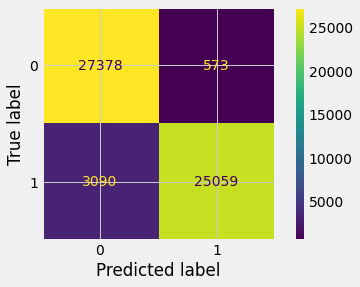




ROC AUC Score 0.9693571692637172
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.14371552951784727

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.367482494246443

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 25632.0, 'FP': 0.0, 'TN': 30468.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.143716,25632.0,30468.0,[0.7775294117646911],1.367482,[0.7775294117646911],0.143716


Wall time: 11min 11s


In [32]:
%%time
runModels(5, 3)

[19:45:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:45:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:45:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

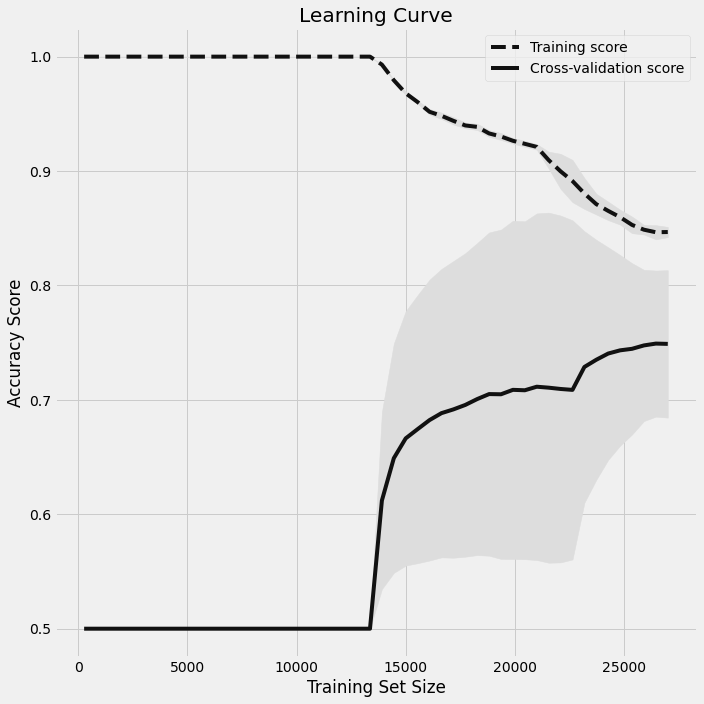

Wall time: 2min 9s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    6224
0    3676
Name: gender, dtype: int64


              counter
churn gender         
0     0          2157
      1          3284
1     0          1519
      1          2940
# # # # # # # # # # 
[[4013  983]
 [1428 3476]]


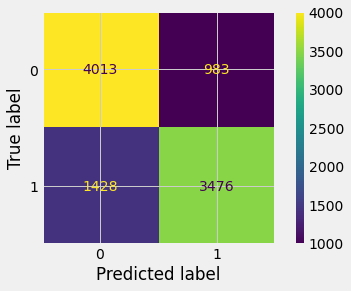




ROC AUC Score 0.8331623496186836
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.05914414628620018

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.874791439970983

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 4459.0, 'FP': 0.0, 'TN': 5441.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.059144,4459.0,5441.0,[0.7551717171717145],0.874791,[0.7551717171717145],-0.059144


Wall time: 2min 22s


In [33]:
%%time
runModels(5, 4)

[19:47:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:47:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

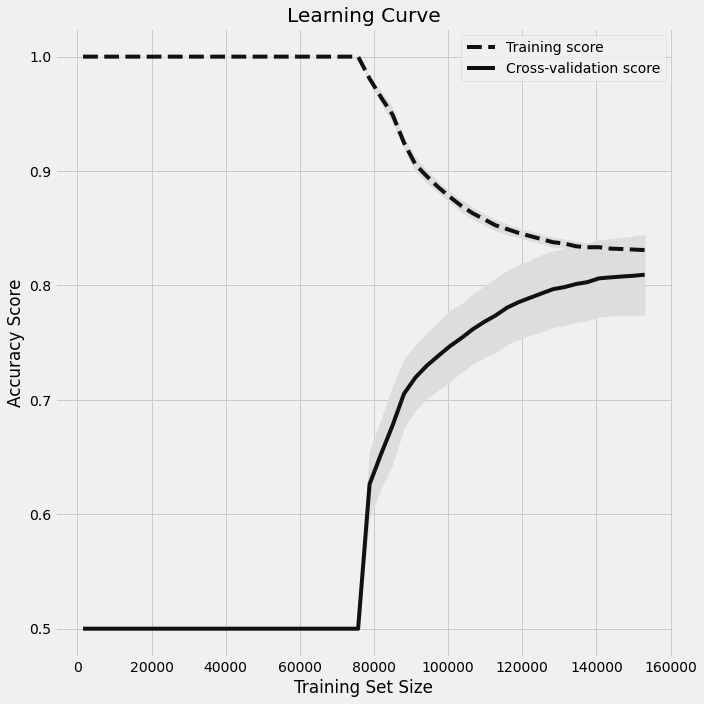

Wall time: 9min 44s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    35231
0    20869
Name: gender, dtype: int64


              counter
churn gender         
0     0         12097
      1         17979
1     0          8772
      1         17252
# # # # # # # # # # 
[[23641  4310]
 [ 6435 21714]]


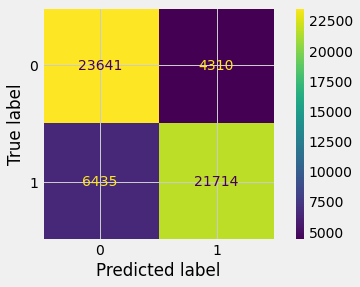




ROC AUC Score 0.8971892429825407
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.06934599788272805

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.8583857609896597

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 26024.0, 'FP': 0.0, 'TN': 30076.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.069346,26024.0,30076.0,[0.813144385026738],0.858386,[0.813144385026738],-0.069346


Wall time: 10min 43s


In [34]:
%%time
runModels(5, 5)

Charn values Original
0    85000
1    15000
Name: churn, dtype: int64
Total data: 100000

Charn values Train
0    56927
1    10073
Name: churn, dtype: int64
Total data: 67000

Charn values Test
0    28073
1     4927
Name: churn, dtype: int64
Total data: 33000


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.82484
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     27703
           1       0.47      0.43      0.45      5297

    accuracy                           0.83     33000
   macro avg       0.68      0.67      0.67     33000
weighted avg       0.82      0.83      0.83     33000

Creating Learning curve for DecisionTreeClassifier - original


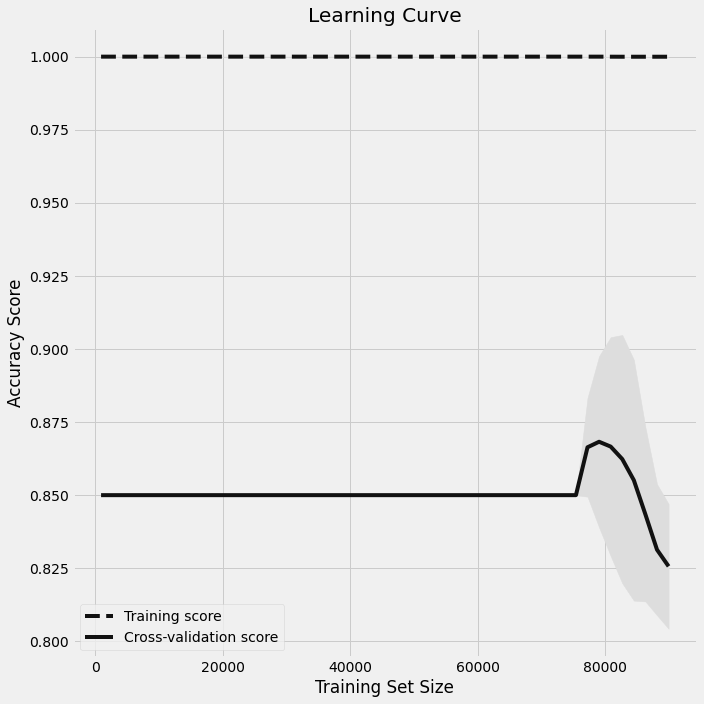

Wall time: 14.9 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    20139
0    12861
Name: gender, dtype: int64


              counter
churn gender         
0     0         10910
      1         16793
1     0          1951
      1          3346
# # # # # # # # # # 
[[25068  3005]
 [ 2635  2292]]


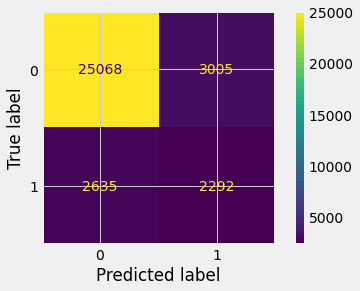




ROC AUC Score 0.6791653420095831
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.014446355468866218

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9130498646779747

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 5297.0, 'FP': 0.0, 'TN': 27703.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.014446,5297.0,27703.0,[0.844775757575776],0.91305,[0.844775757575776],-0.014446


Wall time: 30.6 s


In [35]:
%%time
runModels(6, 1)

Charn values Original
1    85913
0    85000
Name: churn, dtype: int64
Total data: 170913

Charn values Train
1    57569
0    56942
Name: churn, dtype: int64
Total data: 114511

Charn values Test
1    28344
0    28058
Name: churn, dtype: int64
Total data: 56402


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8701639123063704
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     27437
           1       0.90      0.88      0.89     28965

    accuracy                           0.88     56402
   macro avg       0.88      0.88      0.88     56402
weighted avg       0.88      0.88      0.88     56402

Creating Learning curve for DecisionTreeClassifier - adasyn


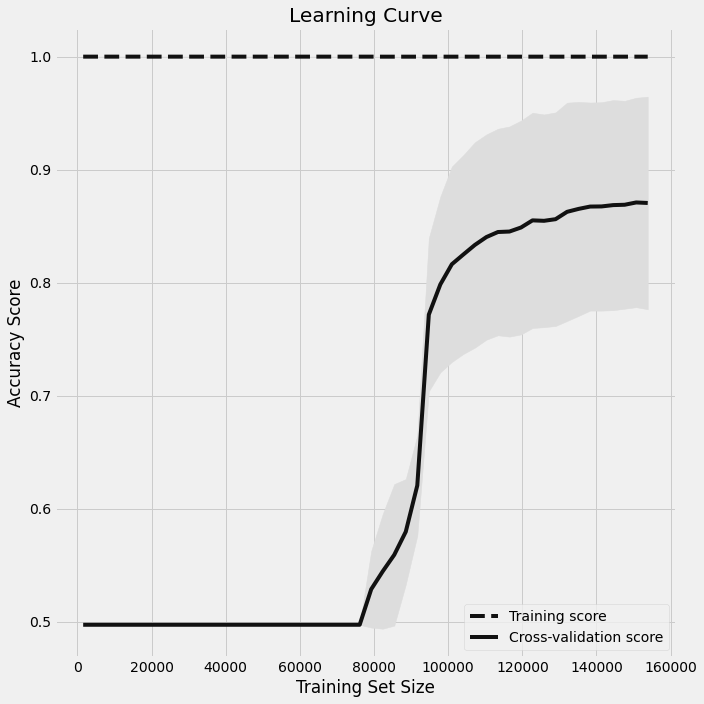

Wall time: 45.3 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30036
0    26366
Name: gender, dtype: int64


              counter
churn gender         
0     0         10850
      1         16587
1     0         15516
      1         13449
# # # # # # # # # # 
[[24483  3575]
 [ 2954 25390]]


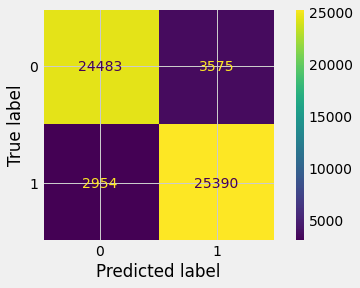




ROC AUC Score 0.8841892876700488
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.14072248551681088

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.3142791713125832

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 28965.0, 'FP': 0.0, 'TN': 27437.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.140722,28965.0,27437.0,[0.7052551327966594],1.314279,[0.7052551327966594],0.140722


Wall time: 1min 33s


In [36]:
%%time
runModels(6, 2)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.8783117647058823
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     27353
           1       0.89      0.88      0.88     28747

    accuracy                           0.88     56100
   macro avg       0.88      0.88      0.88     56100
weighted avg       0.88      0.88      0.88     56100

Creating Learning curve for DecisionTreeClassifier - smote


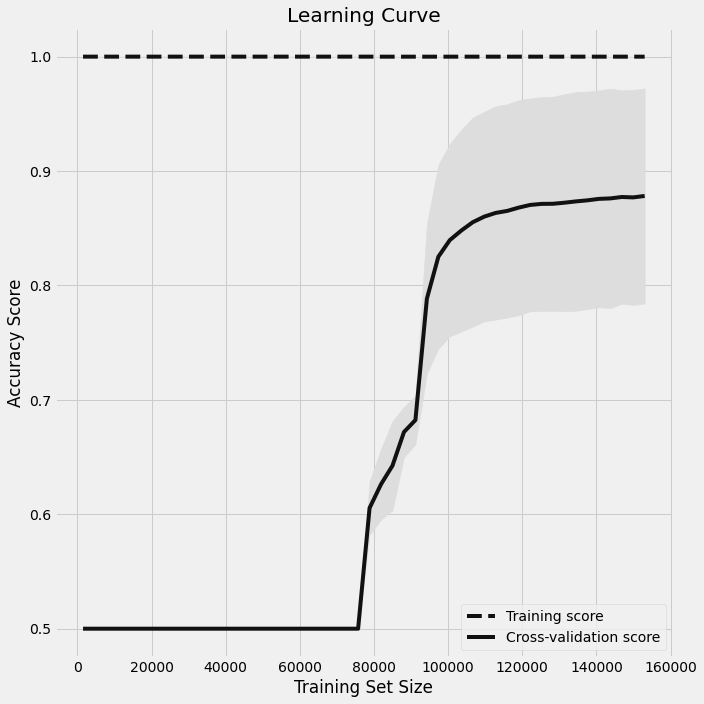

Wall time: 48.7 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    30408
0    25692
Name: gender, dtype: int64


              counter
churn gender         
0     0         10843
      1         16510
1     0         14849
      1         13898
# # # # # # # # # # 
[[24377  3574]
 [ 2976 25173]]


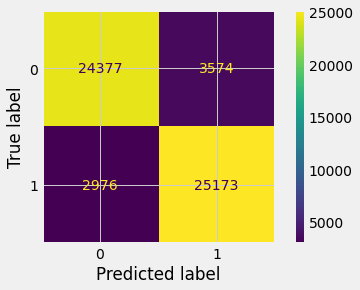




ROC AUC Score 0.8831983162568721
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference 0.12091123540954646

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  1.264546614356993

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 28747.0, 'FP': 0.0, 'TN': 27353.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,0.120911,28747.0,27353.0,[0.7427771836006831],1.264547,[0.7427771836006831],0.120911


Wall time: 1min 18s


In [37]:
%%time
runModels(6, 3)

Charn values Original
1    15000
0    15000
Name: churn, dtype: int64
Total data: 30000

Charn values Train
1    10096
0    10004
Name: churn, dtype: int64
Total data: 20100

Charn values Test
0    4996
1    4904
Name: churn, dtype: int64
Total data: 9900


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.6672
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      4902
           1       0.68      0.66      0.67      4998

    accuracy                           0.67      9900
   macro avg       0.67      0.67      0.67      9900
weighted avg       0.67      0.67      0.67      9900

Creating Learning curve for DecisionTreeClassifier - rus


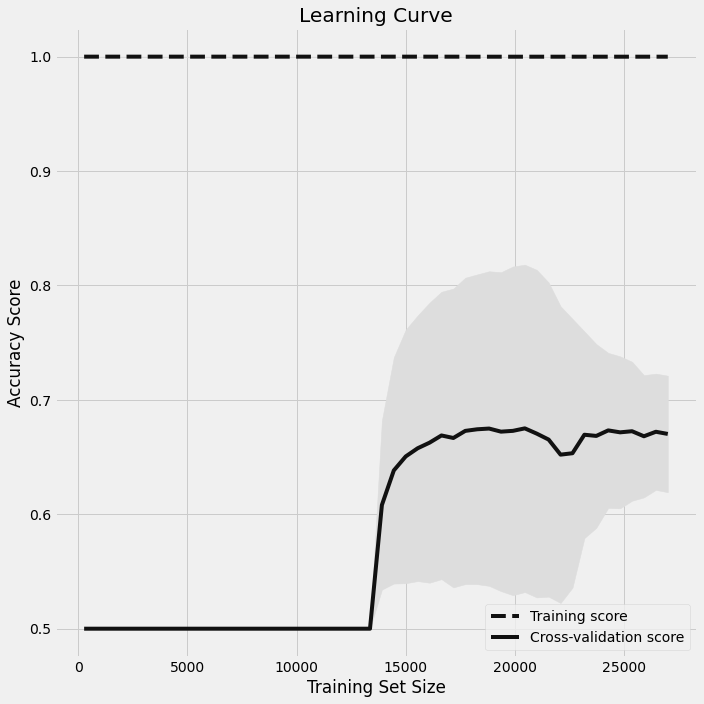

Wall time: 6.49 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    6224
0    3676
Name: gender, dtype: int64


              counter
churn gender         
0     0          1880
      1          3022
1     0          1796
      1          3202
# # # # # # # # # # 
[[3314 1682]
 [1588 3316]]


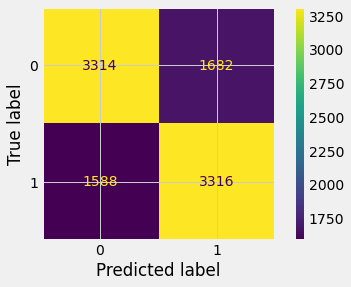




ROC AUC Score 0.6698243178555895
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.025885616700840053

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.9496839230649505

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 4998.0, 'FP': 0.0, 'TN': 4902.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.025886,4998.0,4902.0,[0.68547474747475],0.949684,[0.68547474747475],-0.025886


Wall time: 11.3 s


In [38]:
%%time
runModels(6, 4)

Charn values Original
1    85000
0    85000
Name: churn, dtype: int64
Total data: 170000

Charn values Train
0    57049
1    56851
Name: churn, dtype: int64
Total data: 113900

Charn values Test
1    28149
0    27951
Name: churn, dtype: int64
Total data: 56100


*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
Mean scores : 0.9416058823529413
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     24411
           1       0.99      0.88      0.93     31689

    accuracy                           0.93     56100
   macro avg       0.93      0.93      0.93     56100
weighted avg       0.93      0.93      0.93     56100

Creating Learning curve for DecisionTreeClassifier - ros


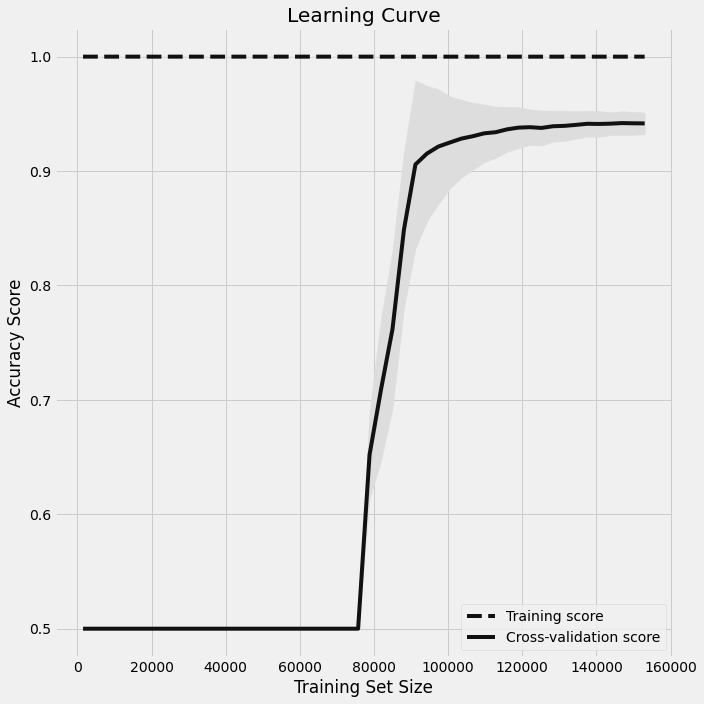

Wall time: 49.8 s

 Gender Count in predited value with X_test set
# # # # # # # # # # 
1    35231
0    20869
Name: gender, dtype: int64


              counter
churn gender         
0     0          9792
      1         14619
1     0         11077
      1         20612
# # # # # # # # # # 
[[24119  3832]
 [  292 27857]]


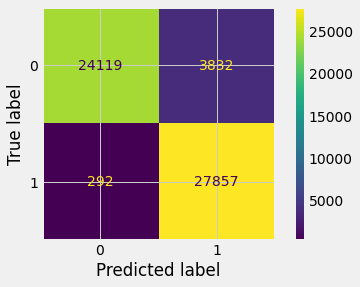




ROC AUC Score 0.9263187875616015
 *  *  *  *  *  *  *  *  *  * 
[{'gender': 1}]

 AIF 360 

 Statistical parity difference -0.054265644178648986

 True possitve rate 1.0 	 True negative rate 1.0 

 Desparate impact  0.907246608283622

 Equal opportunity difference  0.0

 Average odds difference  0.0

 Theil Index  0.0

 Binary Confusion Matric 
{'TP': 31689.0, 'FP': 0.0, 'TN': 24411.0, 'FN': 0.0}

 ..........................


,Attribute,Mean difference,Positive Outcome,Negative,Differences,Disparate impact,Consistency,Statistical parity dif
0,gender,-0.054266,31689.0,24411.0,[0.7567165775400857],0.907247,[0.7567165775400857],-0.054266


Wall time: 1min 15s


In [39]:
%%time
runModels(6, 5)

In [40]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:03:07
